In [6]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

In [7]:
# Note: some of this code was gratefully copied from https://adversarial-ml-tutorial.org/introduction/

In [8]:

# read the image
espresso_img = Image.open("../../data/pictures/kopje.jpg")
preprocess = transforms.Compose([
   transforms.Resize(224),
   transforms.ToTensor(),
])
espresso_tensor = preprocess(espresso_img)[None,:,:,:]


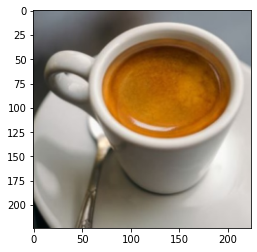

In [9]:

# plot image
plt.imshow(espresso_tensor[0].numpy().transpose(1,2,0))


In [10]:
import torch
import torch.nn as nn
from torchvision.models import resnet50

# simple Module to normalize an image
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]
norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# load pre-trained ResNet50, and put into evaluation mode (necessary to e.g. turn off batchnorm)
model = resnet50(pretrained=True)
model.eval();


In [11]:
pred = model(norm(espresso_tensor))

In [13]:
import json
with open("../../data/models/imagenet_class_index.json") as f:
    imagenet_classes = {int(i):x[1] for i,x in json.load(f).items()}
print("Predicted class: " + imagenet_classes[pred.max(dim=1)[1].item()])


Predicted class: espresso


## Generate an adversary example

In [16]:
import torch.optim as optim
epsilon = 3./255

train_against_label = 967 # The espresso label no.

delta = torch.zeros_like(espresso_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=1e-1)

print("Generating adversary example...")
for t in range(20):
    pred = model(norm(espresso_tensor + delta))
    loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([train_against_label]))
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)
print("Done.")
print("Espresso probability:", nn.Softmax(dim=1)(pred)[0,train_against_label].item())

espresso_adv = (espresso_tensor + delta).data.clamp_(0,1)

Generating adversary example...
Espresso probability: 1.9419437169432285e-09


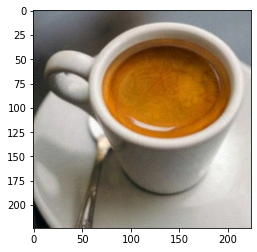

In [17]:

# plot adversary image (note that numpy using HWC whereas Pytorch user CHW, so we need to convert)
plt.imshow(espresso_adv[0].detach().numpy().transpose(1,2,0))


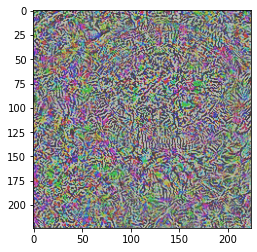

In [18]:

# plot delta (note that numpy using HWC whereas Pytorch user CHW, so we need to convert)
plt.imshow((20*delta+0.5)[0].detach().numpy().transpose(1,2,0))


In [21]:
# Prediction
pred_adv = model(norm(espresso_adv))
print("Predicted class: " + imagenet_classes[pred_adv.max(dim=1)[1].item()])


Predicted class: consomme


## A targeted attack

In [28]:
train_against_label = 967  # Espresso label
target_label = 954         # Banana label
delta = torch.zeros_like(espresso_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=5e-3)

print("Generating adversary example targeted towards 'banana'...")
for t in range(100):
    pred = model(norm(espresso_tensor + delta))
    loss = (-nn.CrossEntropyLoss()(pred, torch.LongTensor([train_against_label])) + 
            nn.CrossEntropyLoss()(pred, torch.LongTensor([target_label])))
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)
print("Done.")
print("Espresso probability:", nn.Softmax(dim=1)(pred)[0,train_against_label].item())
print("Banana probability:", nn.Softmax(dim=1)(pred)[0,target_label].item())


espresso_targeted_adv = (espresso_tensor + delta).data.clamp_(0,1)

Generating adversary example targeted towards 'banana'...
Done.
Espresso probability: 5.473789976642446e-28
Banana probability: 1.0


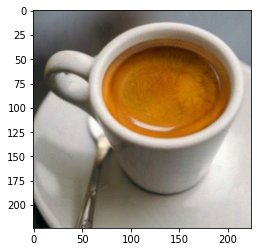

In [29]:

# plot adversary image (note that numpy using HWC whereas Pytorch user CHW, so we need to convert)
plt.imshow(espresso_targeted_adv[0].detach().numpy().transpose(1,2,0))


In [30]:
# Prediction
pred = model(norm(espresso_targeted_adv))
max_class = pred.max(dim=1)[1].item()
print(imagenet_classes[max_class])
print("Predicted class:", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

banana
Predicted class: banana
Predicted probability: 1.0


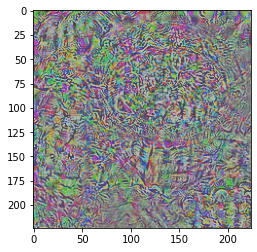

In [31]:

# plot delta (note that numpy using HWC whereas Pytorch user CHW, so we need to convert)
plt.imshow((20*delta+0.5)[0].detach().numpy().transpose(1,2,0))


## Anti-adversarial

Adding some random (normal) noise could mitigate the adversarial power.

In [32]:
#Generate a bit of noise
import numpy as np
noise = torch.from_numpy(np.random.normal(0, 1.5e-2, espresso_tensor.shape)).float()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


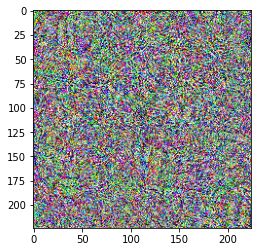

In [33]:

# plot noise
plt.imshow((20*(delta + noise)+0.5)[0].detach().numpy().transpose(1,2,0))


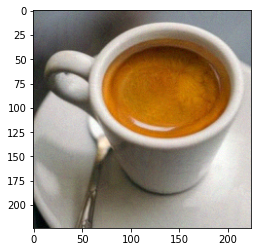

In [34]:

# Adversarial pig with random noise
anti_adversarial = (espresso_targeted_adv + noise).data.clamp_(0,1)
plt.imshow(anti_adversarial[0].detach().numpy().transpose(1,2,0))


In [37]:
# Prediction
pred2 = model(norm(anti_adversarial))
max_class = pred2.max(dim=1)[1].item()
print("Predicted class:", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred2)[0,max_class].item())

Predicted class: espresso
Predicted probability: 0.3150477707386017
